In [7]:
# Import common modules and set global configs
from project_utils.common_imports import *

# Specific imports for data, augmentation, model, and evaluation
from project_utils.loading_utils import main_data_processing_pipeline
from project_utils.data_augmentor_and_generator import data_generator
from project_utils.model_architect import get_vit_model, macro_f1_fn, categorical_focal_loss, UnfreezeBackbone, get_cosine_decay_scheduler
from project_utils.evaluation_utils import evaluate_on_test, plot_training_diagnostics, plot_test_evaluation, CLASS_MAPPING_DICT

# System info
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
GPUs available: 1


In [8]:
class CFG:
    # ─── Static defaults ────────────────────────────────────────────────────────
    seed = 42
    debug = False
    print_freq = 10000
    num_workers = 1

    # Parametric settings
    model_type = "vit" # vit or rescnn
    input_dim = 256             # can be 32, 64, 256, etc.
    use_augmentation   = True
    use_oversampling   = False
    use_class_weights  = False
    use_transfer_learning = True

    # Training hyperparams
    epochs       = 10
    batch_size   = 16
    lr           = 1e-4  # Updated: Start learning rate at 1e-3
    weight_decay = 1e-5
    min_lr       = 1e-6

    # Cross-validation
    n_fold         = 4
    selected_folds = [0, 1, 2, 3]

    # Model / data specifics
    in_channels = 1
    num_classes = 4
    freeze_epochs = 0

    # Augmentation params (adjusted dynamically below)
    noise_std      = 0.1
    max_time_shift = 0.2
    max_freq_shift = 0.2
    max_mask_time  = 0.15
    max_mask_freq  = 0.15

    # ─── Paths ───────────────────────────────────────────────────────────────────
    PROJECT_ROOT_DIR = Path.cwd().parents[2]
    OUTPUT_DIR       = PROJECT_ROOT_DIR / "data/working"
    SPECTROGRAMS_DIR = OUTPUT_DIR / "birdclef25-mel-spectrograms"

    working_df_path  = PROJECT_ROOT_DIR / "data/raw/downsampled_metadata.csv"

    MODELS_DIR     = OUTPUT_DIR / "models"
    PLOTS_DIR      = OUTPUT_DIR / "plots"
    RESULTS_CSV_DIR= OUTPUT_DIR / "result_csvs"

    # ─── Initialization ──────────────────────────────────────────────────────────
    def __init__(self):

        # Minimal seed setting
        os.environ['PYTHONHASHSEED'] = str(self.seed)  # For hash consistency (e.g., dict ordering)
        random.seed(self.seed)                         # Python random
        np.random.seed(self.seed)                      # NumPy random
        tf.random.set_seed(self.seed)                  # TensorFlow/Keras global seed

        # 1) Create dirs
        for d in (self.MODELS_DIR, self.PLOTS_DIR, self.RESULTS_CSV_DIR):
            os.makedirs(d, exist_ok=True)

        # 2) Fix augmentation-dependent params
        if self.use_augmentation:
            self.aug_prob    = 1
            self.mixup_alpha = 0.2

            # Set size-specific augmentation params
            if self.input_dim == 32:
                self.noise_std      = 0.065
                self.max_time_shift = 0.11
                self.max_freq_shift = 0.065
                self.max_mask_time  = 0.125
                self.max_mask_freq  = 0.1
            elif self.input_dim == 64:
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
            else:
                # Fallback for other sizes (e.g., 256); use 64x64 values
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
        else:
            self.aug_prob    = 0.0
            self.mixup_alpha = 0.0

        # 3) Seed RNGs
        random.seed(self.seed)
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

        # 4) Debug override
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

    # ─── Derived properties ─────────────────────────────────────────────────────
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f"birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy"

    @property
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)

    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:      suffix += "_aug"
        if self.use_oversampling:      suffix += "_os"
        if self.use_class_weights:     suffix += "_cw"
        if self.use_transfer_learning: suffix += "_tl"
        if self.model_type.lower() == "vit":
            return f"vit_model_{self.input_dim}{suffix}.keras"
        elif self.model_type.lower() == "rescnn":
            return f"rescnn_model_{self.input_dim}{suffix}.keras"
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}. Use 'vit' or 'rescnn'.")
    
cfg = CFG()

In [9]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (256, 256)


In [10]:
# Run the main pipeline to load data, compute factors/weights, and inspect
combined_train_val_df, test_df, class_weights_dict, filtered_spectrograms = main_data_processing_pipeline(
    cfg, spectrograms, data_generator
)

# For generator usage
class_weights = class_weights_dict if cfg.use_class_weights else None
combined_train_val_df.head(3)  # Display first 3 rows for inspection

# Manage memory usage
del spectrograms
gc.collect()


Loading full dataset...
Train/Val samples: 332
Test samples: 68
Filtered spectrograms to 400 entries
Class counts in train/val: {0: 87, 1: 84, 2: 81, 3: 80}
Computed oversampling factors: {0: 1, 1: 1, 2: 1, 3: 1}

Full dataset class distribution:
 0: Amphibia - 87 samples (26.2%)
 1: Aves - 84 samples (25.3%)
 2: Insecta - 81 samples (24.4%)
 3: Mammalia - 80 samples (24.1%)
Imbalance ratio: Aves / Total = 25.30%

Using uniform class weights.
Final class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

Inspecting one batch from the data generator:
Batch shape: (256, 256, 1)
Example batch labels (one-hot): [0.79185741 0.20814259 0.         0.        ]
Class order: [Amphibia, Aves, Insecta, Mammalia]


31644

In [11]:
# Stratified 80-20 split on combined_train_val_df
train_df, val_df = train_test_split(
    combined_train_val_df, 
    test_size=0.2, 
    stratify=combined_train_val_df['y_species_encoded'],  # Assuming 'label' is the class column; adjust if needed
    random_state=cfg.seed
)

print(f"Train samples after split: {len(train_df)}")
print(f"Validation samples after split: {len(val_df)}")

# Build the model
model = get_vit_model(cfg)
# model.summary()

print(f'The model will be saved as: \n\t\t{cfg.model_save_name}')

Train samples after split: 265
Validation samples after split: 67
The model will be saved as: 
		vit_model_256_aug_tl.keras


In [13]:
# Get Cosine Decay scheduler
cosine_scheduler = get_cosine_decay_scheduler(train_df, cfg)

model.compile(
    optimizer = keras.optimizers.AdamW(
        learning_rate=cosine_scheduler,  # Use scheduler instead of fixed lr
        weight_decay=cfg.weight_decay
    ),
    loss      = "categorical_crossentropy",  # Or categorical_focal_loss() as before
    metrics   = [
        "accuracy",
        macro_f1_fn,
        metrics.AUC(name="auroc", multi_label=True, from_logits=False)
    ],
)

os.makedirs('./logs', exist_ok=True)

# Callbacks (early stopping, checkpoint, unfreeze)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(cfg.MODELS_DIR / cfg.model_save_name, save_best_only=True),
    # TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, update_freq='epoch'),
]

if cfg.use_transfer_learning:
    if cfg.model_type.lower() == "vit":
        callbacks.append(
            UnfreezeBackbone(freeze_epochs=cfg.freeze_epochs, key="vi_t_backbone"),
        )
    elif cfg.model_type.lower() == "rescnn":
        callbacks.append(
            UnfreezeBackbone(freeze_epochs=cfg.freeze_epochs, key="efficient_net"),
        )


train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df, cfg, filtered_spectrograms, class_weights, is_train=True, yield_weight=cfg.use_class_weights),
    output_signature=(
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
    ) if not cfg.use_class_weights else (
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df, cfg, filtered_spectrograms, class_weights, is_train=False, yield_weight=cfg.use_class_weights),
    output_signature=(
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
    ) if not cfg.use_class_weights else (
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model (pass datasets instead of raw generators)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=cfg.epochs,
    callbacks=callbacks,
    class_weight=class_weights if cfg.use_class_weights else None,
    verbose=1
)

[WARN] Unexpected LR type EagerTensor - skipping adjustment.
Epoch 1/10


I0000 00:00:1754327533.309253 1430082 cuda_dnn.cc:529] Loaded cuDNN version 90300


     17/Unknown 29s 195ms/step - accuracy: 0.2460 - auroc: 0.4849 - loss: 1.4264 - macro_f1_fn: 0.1453

2025-08-04 10:12:17.594452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-04 10:12:17.594483: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:12:17.594486: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618
2025-08-04 10:12:17.594987: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[unknown_6/_12]]
2025-08-04 10:12:19.339776: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:12:19.339798: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883
2025-08-04 10:12:

17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 670ms/step - accuracy: 0.2474 - auroc: 0.4867 - loss: 1.4253 - macro_f1_fn: 0.1454 - val_accuracy: 0.3582 - val_auroc: 0.7477 - val_loss: 1.3306 - val_macro_f1_fn: 0.1815
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3259 - auroc: 0.5697 - loss: 1.3563 - macro_f1_fn: 0.2442

2025-08-04 10:12:35.504588: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:12:35.504610: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618
2025-08-04 10:12:35.836438: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:12:35.836456: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883
2025-08-04 10:12:35.836558: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 517ms/step - accuracy: 0.3306 - auroc: 0.5725 - loss: 1.3536 - macro_f1_fn: 0.2480 - val_accuracy: 0.4030 - val_auroc: 0.7675 - val_loss: 1.2789 - val_macro_f1_fn: 0.2104
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3896 - auroc: 0.6008 - loss: 1.3280 - macro_f1_fn: 0.3103

2025-08-04 10:12:44.086376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3635084372527071341
2025-08-04 10:12:44.086400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18183276425433465319
2025-08-04 10:12:44.086410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11278011180514487983
2025-08-04 10:12:44.086416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4439083410156730452
2025-08-04 10:12:46.054146: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:12:46.054165: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 617ms/step - accuracy: 0.3940 - auroc: 0.6015 - loss: 1.3240 - macro_f1_fn: 0.3142 - val_accuracy: 0.5224 - val_auroc: 0.8345 - val_loss: 1.1443 - val_macro_f1_fn: 0.3163
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5145 - auroc: 0.6645 - loss: 1.1716 - macro_f1_fn: 0.4351

2025-08-04 10:12:54.303478: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:12:54.303512: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618
2025-08-04 10:12:56.287476: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:12:56.287495: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883
2025-08-04 10:12:56.287552: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 617ms/step - accuracy: 0.5175 - auroc: 0.6655 - loss: 1.1667 - macro_f1_fn: 0.4372 - val_accuracy: 0.5970 - val_auroc: 0.8564 - val_loss: 0.9712 - val_macro_f1_fn: 0.3836
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6951 - auroc: 0.7369 - loss: 0.9104 - macro_f1_fn: 0.6567

2025-08-04 10:13:04.538938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3635084372527071341
2025-08-04 10:13:04.538964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18183276425433465319
2025-08-04 10:13:04.538969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11278011180514487983
2025-08-04 10:13:04.538976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4439083410156730452
2025-08-04 10:13:06.576455: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:13:06.576477: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 639ms/step - accuracy: 0.6953 - auroc: 0.7364 - loss: 0.9081 - macro_f1_fn: 0.6552 - val_accuracy: 0.6269 - val_auroc: 0.8709 - val_loss: 0.9315 - val_macro_f1_fn: 0.4208
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6512 - auroc: 0.7410 - loss: 0.9001 - macro_f1_fn: 0.6118

2025-08-04 10:13:15.054163: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:13:15.054198: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.6551 - auroc: 0.7416 - loss: 0.8945 - macro_f1_fn: 0.6123 - val_accuracy: 0.5672 - val_auroc: 0.8697 - val_loss: 1.0238 - val_macro_f1_fn: 0.3654
Epoch 7/10


2025-08-04 10:13:15.382795: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:13:15.382824: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7411 - auroc: 0.7644 - loss: 0.7805 - macro_f1_fn: 0.7278

2025-08-04 10:13:18.695723: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:13:18.695744: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618
2025-08-04 10:13:20.496847: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:13:20.496870: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 635ms/step - accuracy: 0.7420 - auroc: 0.7646 - loss: 0.7786 - macro_f1_fn: 0.7282 - val_accuracy: 0.6567 - val_auroc: 0.9078 - val_loss: 0.8057 - val_macro_f1_fn: 0.4709
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8228 - auroc: 0.7778 - loss: 0.6556 - macro_f1_fn: 0.7957

2025-08-04 10:13:29.155413: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:13:29.155438: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618
2025-08-04 10:13:29.462464: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:13:29.462486: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 532ms/step - accuracy: 0.8244 - auroc: 0.7774 - loss: 0.6536 - macro_f1_fn: 0.7975 - val_accuracy: 0.7015 - val_auroc: 0.9135 - val_loss: 0.7798 - val_macro_f1_fn: 0.5067
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8265 - auroc: 0.7672 - loss: 0.6698 - macro_f1_fn: 0.7854

2025-08-04 10:13:39.404593: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:13:39.404618: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 854ms/step - accuracy: 0.8259 - auroc: 0.7676 - loss: 0.6689 - macro_f1_fn: 0.7847 - val_accuracy: 0.7015 - val_auroc: 0.9110 - val_loss: 0.7866 - val_macro_f1_fn: 0.5159
Epoch 10/10


2025-08-04 10:13:49.970549: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-04 10:13:49.970573: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:13:49.970575: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8395 - auroc: 0.7720 - loss: 0.6291 - macro_f1_fn: 0.8305

2025-08-04 10:13:53.244906: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5529316313377753220
2025-08-04 10:13:53.244926: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 856411110660121618


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.8398 - auroc: 0.7722 - loss: 0.6279 - macro_f1_fn: 0.8300 - val_accuracy: 0.7015 - val_auroc: 0.9103 - val_loss: 0.7858 - val_macro_f1_fn: 0.5130


2025-08-04 10:13:55.045412: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 3668390880149873661
2025-08-04 10:13:55.045433: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 9118541686524148883


In [14]:
# Evaluate on test set
y_true, y_pred_prob = evaluate_on_test(model, cfg, filtered_spectrograms, test_df)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step

Test Loss: 0.9953
Test AUC: 0.8255
Test Accuracy: 0.5588


Training curves saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/training_curves_256vit_model_256_aug_tl.png


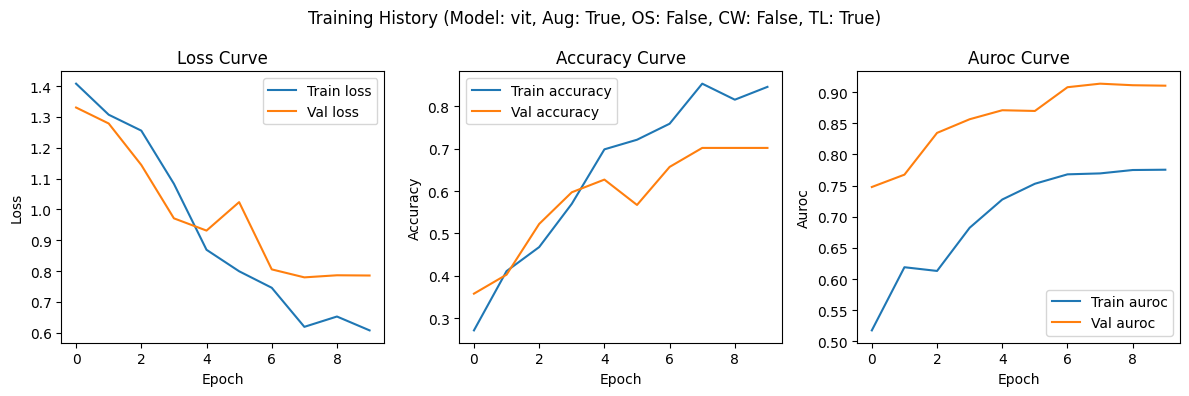

Confusion matrix saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/confusion_matrix_256vit_model_256_aug_tl.png


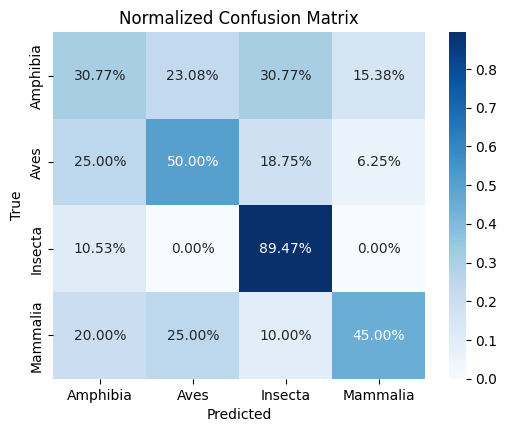

Per-class metrics saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/per_class_metrics_256vit_model_256_aug_tl.png


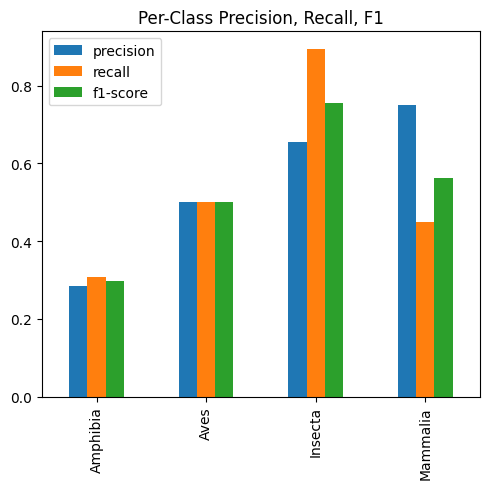

Test evaluation plot saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/test_evaluation_256vit_model_256_aug_tl.png


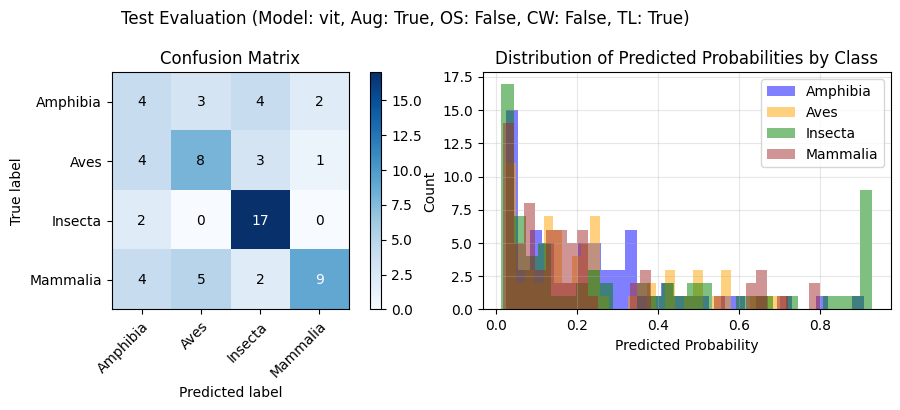

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_256vit_model_256_aug_tl.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.29      0.31      0.30        13
        Aves       0.50      0.50      0.50        16
     Insecta       0.65      0.89      0.76        19
    Mammalia       0.75      0.45      0.56        20

    accuracy                           0.56        68
   macro avg       0.55      0.54      0.53        68
weighted avg       0.58      0.56      0.55        68



In [15]:
# Plot training diagnostics
plot_training_diagnostics(history, cfg,  y_true, y_pred_prob, CLASS_MAPPING_DICT)

# Plot test evaluation (confusion matrix, report)
plot_test_evaluation(y_true, y_pred_prob, class_mapping=CLASS_MAPPING_DICT, cfg=cfg)